<a href="https://colab.research.google.com/github/enakai00/cirq_examples/blob/master/Phase_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cirq をインストールします。

In [0]:
pip install cirq==0.7.0

必要なモジュールをインポートします。

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq

逆フーリエ変換を量子回路で実装する例です。

In [0]:
class InverseQft(cirq.Gate):
    """Quantum gate for the Inverse Quantum Fourier Transformation
    """

    def __init__(self, num_qubits):
        super(InverseQft, self)
        self._num_qubits = num_qubits

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        """A quantum circuit with the following structure
        (swaps at the end of the circuit are omitted.)
        ---H--@-------@--------@----------------------------------------------
              |       |        |
        ------@^-0.5--+--------+---------H--@-------@-------------------------
                      |        |            |       |
        --------------@^-0.25--+------------@^-0.5--+---------H--@------------
                               |                    |            |
        -----------------------@^-0.125-------------@^-0.25------@^-0.5---H---
        The number of qubits can be arbitrary.
        """

        _qubits = list(qubits)
        while len(_qubits) > 0:
            q_head = _qubits.pop(0)
            yield cirq.H(q_head)
            for i, qubit in enumerate(_qubits):
                yield (cirq.CZ(qubit, q_head)**(-1/2.0**(i+1)))

        _qubits = list(qubits)
        while len(_qubits) > 1:
            yield (cirq.SWAP(_qubits[0], _qubits[-1]))
            _qubits = _qubits[1:-1]

    def __str__(self):
        return 'InverseQFT'

    def __repr__(self):
        return ('cirq.InverseQft(num_qubits={!r})'.format(self._num_qubits))

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'):
        return cirq.CircuitDiagramInfo(
            wire_symbols=(str(self),) +
            tuple(f'#{k+1}' for k in range(1, self._num_qubits)),
            exponent_qubit_index=0)

指定した位相の固有値を持つユニタリゲートを定義します。固有ベクトルは |0> です。

In [0]:
def example_gate(phi):
    """An example unitary 1-qubit gate U with an eigen vector |0> and an
    eigen value exp(2*Pi*i*phi)
    """

    gate = cirq.MatrixGate(
        matrix=np.array([[np.exp(2 * np.pi * 1.0j * phi), 0], [0, 1]]))
    return gate

先ほど定義したユニタリゲートの位相推定を行います。

In [6]:
qnum = 8

for _ in range(10):
  phase = np.random.random()

  ancilla = cirq.LineQubit(-1)
  qubits = cirq.LineQubit.range(qnum)

  oracle_raised_to_power = [
     example_gate(phase).on(ancilla).controlled_by(qubits[-(i+1)])**(2**i) for i in range(qnum)
  ]
  circuit = cirq.Circuit(cirq.H.on_each(*qubits), oracle_raised_to_power,
                         InverseQft(qnum)(*qubits),
                         cirq.measure(*qubits, key='phase'))

  result = cirq.sample(circuit, repetitions=100)
  mean = np.mean(result.data['phase'])
  estimate = mean / 2**qnum
  print(f'phase={phase:0.4f}, estimate={estimate:0.4f}')

phase=0.9577, estimate=0.9568
phase=0.3143, estimate=0.3170
phase=0.4941, estimate=0.4954
phase=0.8768, estimate=0.8764
phase=0.7079, estimate=0.7069
phase=0.2407, estimate=0.2472
phase=0.7066, estimate=0.7069
phase=0.6294, estimate=0.6287
phase=0.6144, estimate=0.6165
phase=0.2808, estimate=0.2812


複数の固有値に対する重ね合わせ状態に対しては、それぞれの固有値（の位相）が等確率で検出されます。

In [0]:
def example_gate2(phis):
    phi0, phi1, phi2, phi3 = phis
    gate = cirq.MatrixGate(
        matrix=np.array([[np.exp(2 * np.pi * 1.0j * phi0), 0, 0, 0], 
                         [0, np.exp(2 * np.pi * 1.0j * phi1), 0, 0],
                         [0, 0, np.exp(2 * np.pi * 1.0j * phi2), 0],
                         [0, 0, 0, np.exp(2 * np.pi * 1.0j * phi3)]
                         ]))
    return gate

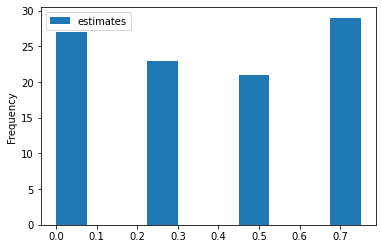

In [8]:
qnum = 8
gate = example_gate2([0, 0.25, 0.50, 0.75])

ancilla = cirq.LineQubit.range(0, 2)
qubits = cirq.LineQubit.range(2, 2+qnum)

results = []
for _ in range(100):
  oracle_raised_to_power = [
    gate.on(*ancilla).controlled_by(qubits[-(i+1)])**(2**i) for i in range(qnum)
  ]
  circuit = cirq.Circuit(
    cirq.H.on_each(*ancilla),
    cirq.H.on_each(*qubits), oracle_raised_to_power,
                       InverseQft(qnum)(*qubits),
                       cirq.measure(*qubits, key='phase'))

  result = cirq.sample(circuit, repetitions=30)
  mode = result.data['phase'].mode()[0]
  estimate = mode / 2**qnum
  results.append(estimate)

DataFrame({'estimates': results}).plot(kind='hist')